In [21]:
import calour as ca
import calour_utils as cu

failed to load logging config file


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import shutil
import matplotlib.colors
import skbio as skbio
import seaborn as sbs

# To run the classifier for multiple repeats
## We run it on our server using the following commands:
(to create 25 runs of 3 types:
normal
shuffledest - shuffle the case/control labels of the validation dataset
shufflesrc - shuffle the case/control labels of the training dataset

cd ../classifier
conda activate calour2

nohup ./run_classifier_batch.sh 25 -i ../allsamples/allsamples-no-subsampling-no-bloom.biom -m ../allsamples/allsamples-no-subsampling-no-bloom_sample.txt -o results/regular --uname &

nohup ./run_classifier_batch.sh 25 -i ../allsamples/allsamples-no-subsampling-no-bloom.biom -m ../allsamples/allsamples-no-subsampling-no-bloom_sample.txt -o results/shufflesrc --shuffle-source --uname &

nohup ./run_classifier_batch.sh 25 -i ../allsamples/allsamples-no-subsampling-no-bloom.biom -m ../allsamples/allsamples-no-subsampling-no-bloom_sample.txt -o results/shuffledest --shuffle --uname &


## Output is 3*25 csv files of AUC values
copy them back to here to ../classifier/results/ directory

# load the classifier results

In [23]:
dat=ca.read_amplicon('../allsamples/allsamples-no-subsampling-no-bloom.biom','../allsamples/allsamples-no-subsampling-no-bloom_sample.txt',min_reads=1000,normalize=10000)

/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,69,70,71,72,73,75,77,79,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,106,107,108,109,110,113,114,115,118,119,120,121,122,123,124,125,127,129,131,132,133,134,135,136,137,138,140,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,239,240,241,242,243,260,261,263,264,265,266,267,268,269,270,271,272,273,274,275,276,278,280,281,282,283,284,285,286,288,289,292,293,294,295,297,299,300,30

2021-04-07 16:07:20 WARNING Do you forget to normalize your data? It is required before running this function


In [109]:
def load_resuts(filename):
    print('---------')
    print('loading %s' % filename)
    res=None
    numres = 0
    for cres in glob.glob(filename):
        cdf=pd.read_csv(cres,index_col=0)
        if res is None:
            res = cdf
            numres = 1
            continue
        if np.sum(np.sum(np.isnan(cdf)))>0:
            print('nan in %s in %s' % (cres,filename))
            continue
        if not cdf.columns.equals(res.columns):
            print('error')
        res += cdf
        numres += 1
    if numres == 0:
        raise ValueError('No experiments found for %s' % filename)
    res = res/numres
    print('loaded %d results' % numres)
    return res

In [105]:
studies=pd.read_csv('../studies/index.csv',sep='\t')
studies=studies.fillna(1000)
studies['mf']=studies['sampleid'].astype(int).astype(str)

In [106]:
def plot_clustergram(roc_mat, studies,metric='correlation'):
    ids = [str(x) for x in roc_mat.index.values]
    labels2=[(studies.loc[studies['mf']==str(x),'disease'].values + '(' + studies.loc[studies['mf']==str(x), 'authors'].values + ')')[0] for x in ids]
    labelsd2=[(studies.loc[studies['mf']==str(x),'disease'].values + '(' + studies.loc[studies['mf']==str(x), 'authors'].values + ')' + ' ' + str(x))[0] for x in ids]

    # set up the colors for disease
    diseases = {xx:studies.loc[studies['mf']==xx,'disease'].values[0] for xx in ids}
    disease_colors = {xx:(0,0,0) for xx in diseases.values()}
    disease_colors.update({'HIV': (1.00,0.93,0.35),'Autism': (0.50,0.99,0.52),'Bipolar': (1.00, 0.63, 0.00),
         'IBD_Crohn disease': (0.72,0.11,0.11),'IBD_Ulcerative Colitis': (0.72,0.11,0.11),
         'IBD_Inflammtory bowel disease': (0.72,0.11,0.11),
         'Diabetes T2': (0.47,0.53,0.80),
         'Depression': (0.48,0.12,0.64),
         'Obesity': (0.25,0.32,0.71),
         'Parkinson': (0.29,0.08,0.55),
         'Schizophrenia': (0.88,0.75,0.91),     
         'Gastroenteritis': (0.94,0.33,0.31),
         'Heart diseases': (0.33,0.43,1.00),
         'Irritable bowel syndrom': (0.90,0.45,0.45),
         'Alzheimer': (0.83, 0.83, 0.83), 'Anorexia': (0.83, 0.83, 0.83), 'Cancer': (0.83, 0.83, 0.83), 'Autoimmun diseases': (0.83, 0.83, 0.83), 'C.difficile infection': (0.83, 0.83, 0.83), 
         'Cancer': (0.83, 0.83, 0.83), 'Chronic fatigue syndrome': (0.83, 0.83, 0.83), 'Diabetes T1': (0.83, 0.83, 0.83),  'Gout': (0.83, 0.83, 0.83),
         'Hepatitis B': (0.83, 0.83, 0.83), 'Hepatitis C': (0.83, 0.83, 0.83), 'Hypertension': (0.83, 0.83, 0.83), 
         'Lupus': (0.83, 0.83, 0.83), 'Pancreatitis': (0.83, 0.83, 0.83), 'Psoriasis': (0.83, 0.83, 0.83), 'Rheumatoid arthritis': (0.83, 0.83, 0.83), 
                
         })

    sbs.set(font_scale=0.6)
#     f=sbs.clustermap(roc_mat,xticklabels=labels2,yticklabels=labels2,cmap='nipy_spectral',metric='cosine',vmin=0,vmax=1,
    f=sbs.clustermap(roc_mat,xticklabels=labels2,yticklabels=labels2,cmap='seismic_r',metric=metric,vmin=0,vmax=1,
                    row_colors=[disease_colors[diseases[x]] for x in ids],
                    col_colors=[disease_colors[diseases[x]] for x in ids])
    row_order = np.array(f.dendrogram_row.reordered_ind)
    col_order = np.array(f.dendrogram_col.reordered_ind)
    for idx,crow in enumerate(row_order):
        ccol = np.where(col_order==crow)[0]
        f.ax_heatmap.plot([ccol,ccol,ccol+0.9,ccol+0.9,ccol],[idx,idx+0.9,idx+0.9,idx,idx],'k',linewidth=1)
    return f

In [110]:
resreal=load_resuts('../classifier/results/regular*roc.csv')
resshufall=load_resuts('../classifier/results/shuffleall*roc.csv')
resshufdest=load_resuts('../classifier/results/shuffledest*roc.csv')
resshufsrc=load_resuts('../classifier/results/shufflesrc*')

---------
loading ../classifier/results/regular*roc.csv
nan in ../classifier/results/regular_13d76b40-97d5-11eb-869a-633eca66d98e_roc.csv in ../classifier/results/regular*roc.csv
nan in ../classifier/results/regular_13e47042-97d5-11eb-8c67-29ccd9ca4ba1_roc.csv in ../classifier/results/regular*roc.csv
nan in ../classifier/results/regular_13efe62a-97d5-11eb-8d2e-a180eace8ae2_roc.csv in ../classifier/results/regular*roc.csv
loaded 47 results
---------
loading ../classifier/results/shuffleall*roc.csv
nan in ../classifier/results/shuffleall_29a9df58-97d9-11eb-8360-9787261da95e_roc.csv in ../classifier/results/shuffleall*roc.csv
nan in ../classifier/results/shuffleall_29937326-97d9-11eb-bdd3-a358c3b277ee_roc.csv in ../classifier/results/shuffleall*roc.csv
nan in ../classifier/results/shuffleall_2940367a-97d9-11eb-991f-6d98312de368_roc.csv in ../classifier/results/shuffleall*roc.csv
nan in ../classifier/results/shuffleall_2967a8b8-97d9-11eb-a077-e7799af834b5_roc.csv in ../classifier/results/s

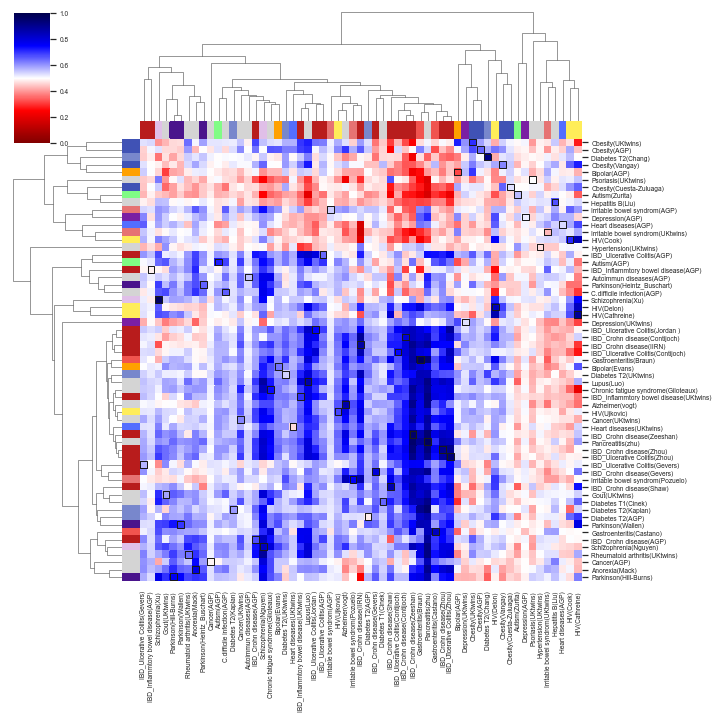

In [111]:
f=plot_clustergram(resreal, studies)
f.savefig('../figures/fig5/ensemble-classifier.pdf')

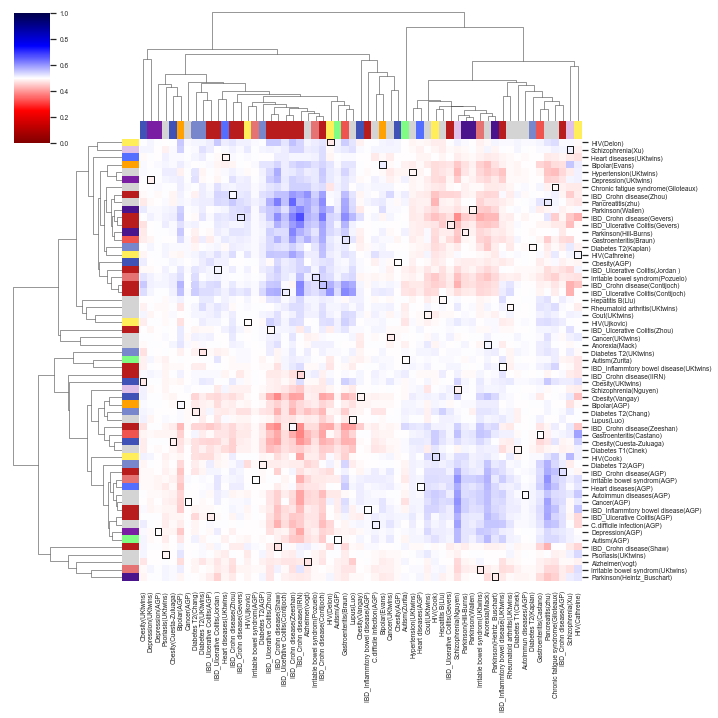

In [112]:
f=plot_clustergram(resshufsrc, studies)
f.savefig('../figures/fig5/ensemble-classifier-shuffle-source.pdf')

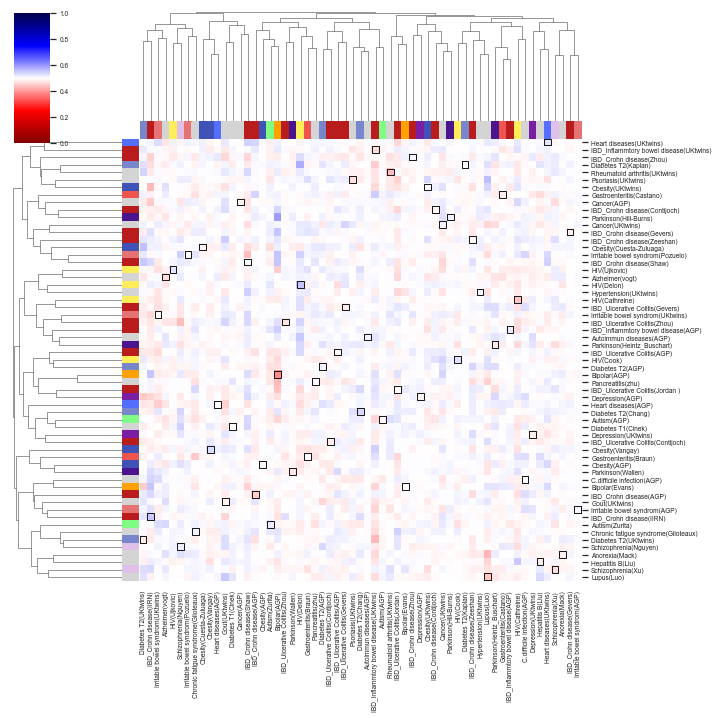

In [113]:
f=plot_clustergram(resshufdest,studies)
f.savefig('../figures/fig5/ensemble-classifier-shuffle-dest.pdf')

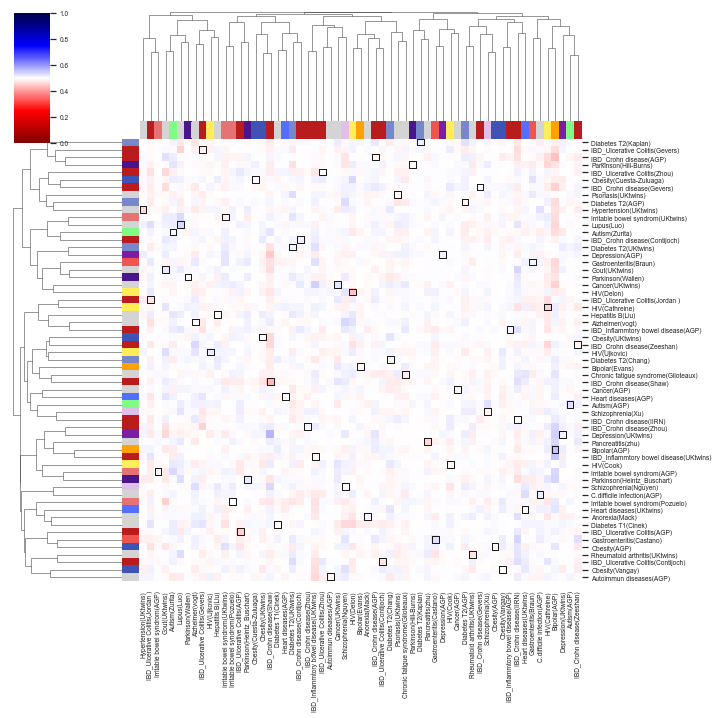

In [114]:
f=plot_clustergram(resshufall,studies)
f.savefig('../figures/fig5/ensemble-classifier-shuffle-all.pdf')

# Now plot the accuracy (corrected)

In [124]:
accreal=load_resuts('../classifier/results/regular*accuracy.csv')
accshufall=load_resuts('../classifier/results/shuffleall*accuracy.csv')
accshufdest=load_resuts('../classifier/results/shuffledest*accuracy.csv')
accshufsrc=load_resuts('../classifier/results/shufflesrc*')

---------
loading ../classifier/results/regular*accuracy.csv
nan in ../classifier/results/regular_13efe62a-97d5-11eb-8d2e-a180eace8ae2_accuracy.csv in ../classifier/results/regular*accuracy.csv
nan in ../classifier/results/regular_13e47042-97d5-11eb-8c67-29ccd9ca4ba1_accuracy.csv in ../classifier/results/regular*accuracy.csv
nan in ../classifier/results/regular_13d76b40-97d5-11eb-869a-633eca66d98e_accuracy.csv in ../classifier/results/regular*accuracy.csv
loaded 47 results
---------
loading ../classifier/results/shuffleall*accuracy.csv
nan in ../classifier/results/shuffleall_29937326-97d9-11eb-bdd3-a358c3b277ee_accuracy.csv in ../classifier/results/shuffleall*accuracy.csv
nan in ../classifier/results/shuffleall_2940367a-97d9-11eb-991f-6d98312de368_accuracy.csv in ../classifier/results/shuffleall*accuracy.csv
nan in ../classifier/results/shuffleall_2967a8b8-97d9-11eb-a077-e7799af834b5_accuracy.csv in ../classifier/results/shuffleall*accuracy.csv
nan in ../classifier/results/shuffleall_2

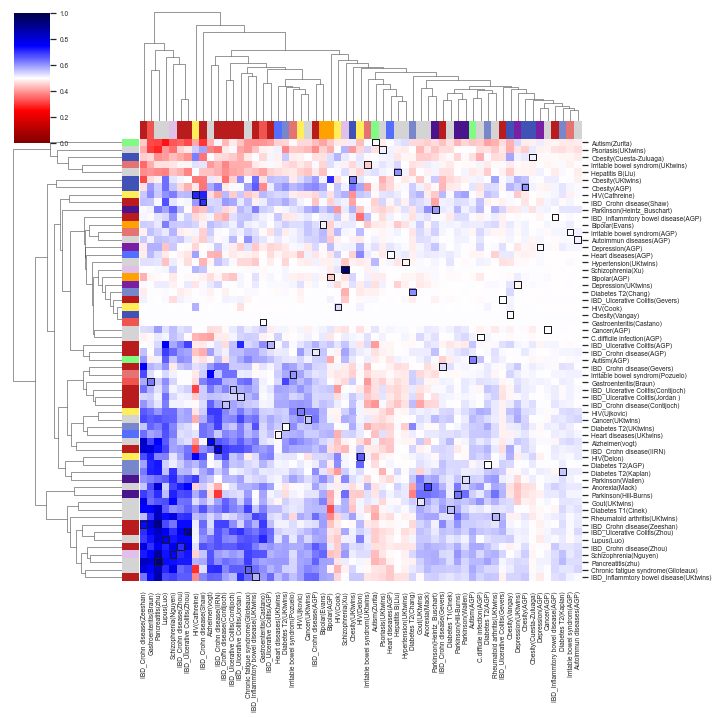

In [120]:
f=plot_clustergram(accreal, studies,metric='braycurtis')
f.savefig('../figures/fig5/ensemble-classifier-accuracy.pdf')

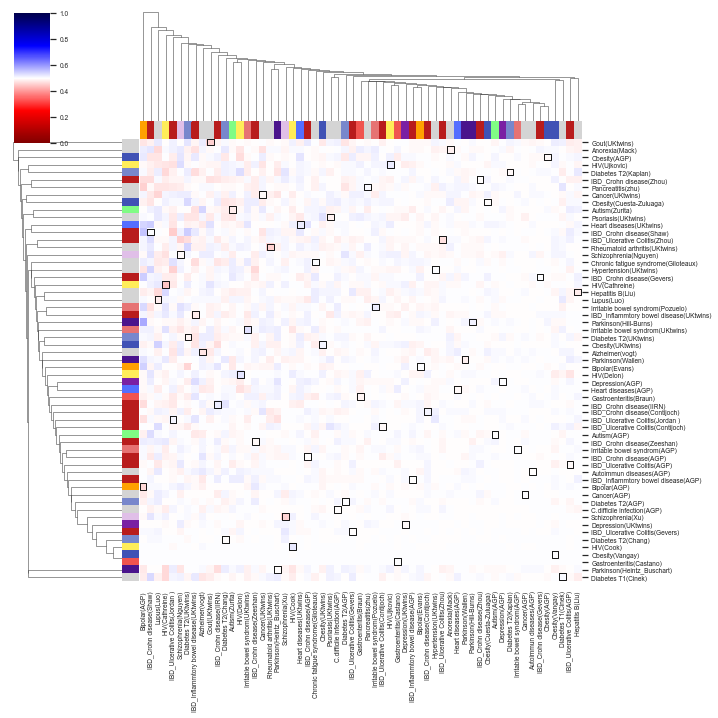

In [121]:
f=plot_clustergram(accshufdest,studies,metric='braycurtis')
f.savefig('../figures/fig5/ensemble-classifier-accuracy-shuffle-dest.pdf')

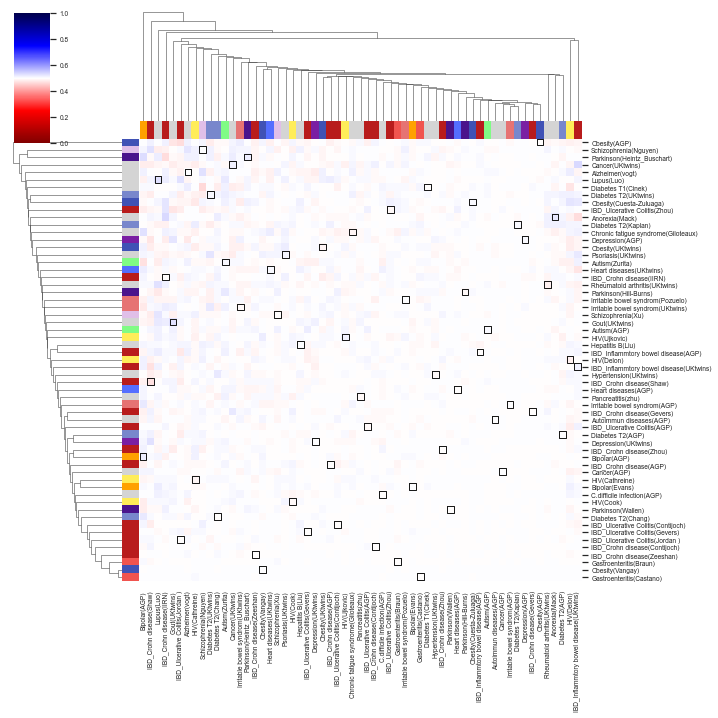

In [122]:
f=plot_clustergram(accshufall,studies,metric='braycurtis')
f.savefig('../figures/fig5/ensemble-classifier-accuracy-shuffle-all.pdf')

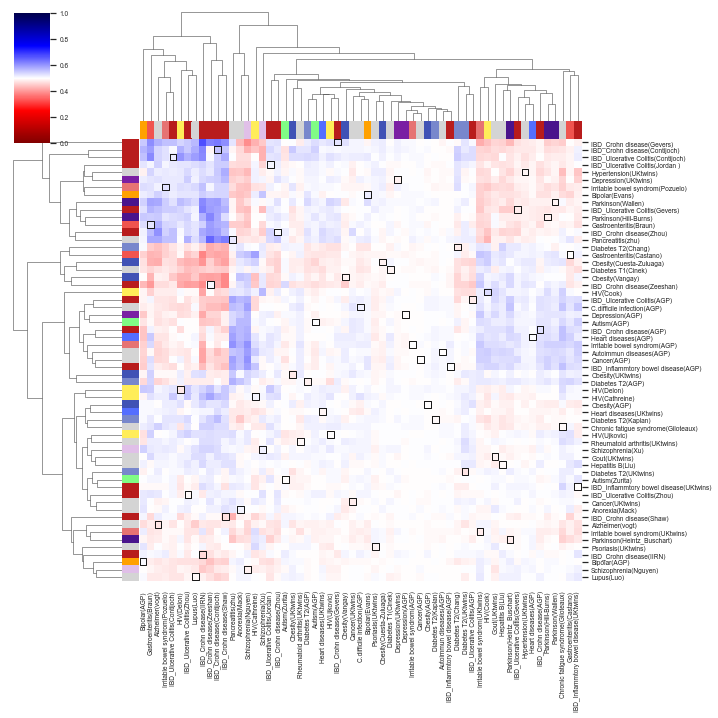

In [125]:
f=plot_clustergram(accshufsrc,studies,metric='braycurtis')
f.savefig('../figures/fig5/ensemble-classifier-accuracy-shuffle-source.pdf')

In [23]:
studies

,sampleid,disease,authors,merged,study,Country,sample_source,updated,notes,2,3,4,5,mf
0,1,Schizophrenia,Nguyen,Schizophrenia (Nguyen),nguyen,USA,stool,V,search for gender,11710:11710.10317.000084453,11710:11710.10317.000084288,1000.0,1000.0,1
1,18,Schizophrenia,Xu,Schizophrenia (Xu),xu,China,stool,V,1000,adults,1000,1000.0,1000.0,18
2,55,Rheumatoid arthritis,UKtwins,Rheumatoid arthritis (Uktwins),uktwins,UK,stool,V,females,adults,1000,1000.0,1000.0,55
3,57,Psoriasis,UKtwins,Psoriasis (Uktwins),uktwins,UK,stool,V,females,adults,1000,1000.0,1000.0,57
4,3,Parkinson,Hill-Burns,Parkinson (Hill-Burns),Hill-Burns,USA,stool,V,good,adults,1000,1000.0,1000.0,3
5,4,Parkinson,Heintz_Buschart,Parkinson (Heintz-Buschart),Heintz_Buschart,Germany,stool,V,No gender metadata,adults,1000,1000.0,1000.0,4
6,5,Parkinson,Wallen,Parkinson (Wallen),"Wallen, 2020",USA,stool,1000,1000,adults,1000,1000.0,1000.0,5
7,14,Pancreatitis,zhu,Pancreatitis (Zhu),zhu,China,stool,V,No gender metadata,adults,1000,1000.0,1000.0,14
8,7,Obesity,Cuesta-Zuluaga,Obesity (de la Cuesta-Zuluaga),Cuesta-Zuluaga,Colombia,stool,V,good,adults,1000,1000.0,1000.0,7
9,20,Obesity,Vangay,Obesity (Vangay),vangay,Multi,stool,V,1000,adults,1000,1000.0,1000.0,20


# whats going on with #36 (bipolar agp)

In [321]:
allres=[]
for i in range(25):
    exp1=dat.filter_samples('expid','36')
    exp1=exp1.downsample('type',axis='s')

#     exp1.sample_metadata['type'] = exp1.sample_metadata['type'].sample(frac=1).values    
    
    exp1.sample_metadata.disease.unique()
    exp1 = exp1.filter_sum_abundance(0,strict=True)
    exp1.sparse=False
    
    cexp1 = exp1.downsample('expid',keep=2*int(len(exp1.sample_metadata)/3))
    cexp2 = exp1.filter_ids(cexp1.sample_metadata.index,axis='s',negate=True)

    model=cu.classify_fit(cexp1,'type')
    res=cu.classify_predict(cexp2, 'type', model,plot_it=False)
    roc_auc = cu.classify_get_roc(res)
    if not np.isnan(roc_auc):
        allres.append(roc_auc)
print(allres)
print(np.mean(allres))
print(np.std(allres))

2021-01-09 18:30:53 WARNING The class 'disease' is skipped because the true positive rate or false positive rate computation failed. This is likely because you have either no true positive or no negative samples for this class
2021-01-09 18:30:53 WARNING The class 'disease' is skipped because the true positive rate or false positive rate computation failed. This is likely because you have either no true positive or no negative samples for this class


/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:805: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:89: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


2021-01-09 18:30:55 WARNING The class 'HC' is skipped because the true positive rate or false positive rate computation failed. This is likely because you have either no true positive or no negative samples for this class
2021-01-09 18:30:55 WARNING The class 'HC' is skipped because the true positive rate or false positive rate computation failed. This is likely because you have either no true positive or no negative samples for this class


/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:805: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:89: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


[0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.33333333333333337, 0.16666666666666666, 0.5, 0.5, 0.33333333333333337, 0.0, 0.0, 0.3333333333333333, 1.0, 0.0, 0.25, 0.0, 0.0, 0.5, 0.0, 0.125, 0.0]
0.21920289855072464
0.2624374181508892


In [296]:
exp1 = exp1.filter_sum_abundance(0,strict=True)
exp1.sparse=False

In [297]:
cexp1 = exp1.downsample('expid',keep=2*int(len(exp1.sample_metadata)/3))
cexp2 = exp1.filter_ids(cexp1.sample_metadata.index,axis='s',negate=True)


In [298]:
cexp1

AmpliconExperiment with 8 samples, 904 features

In [299]:
cexp2

AmpliconExperiment with 4 samples, 904 features

In [300]:
exp1

AmpliconExperiment with 12 samples, 904 features

In [301]:
model=cu.classify_fit(cexp1,'type')


0.0

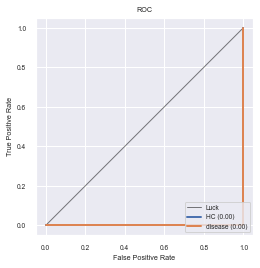

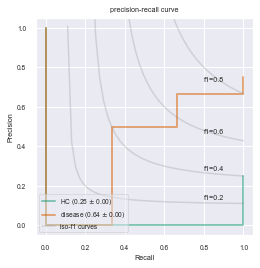

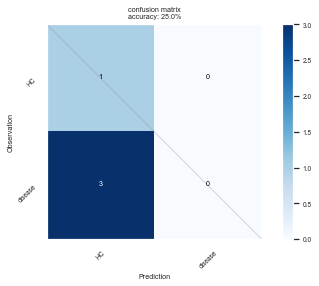

In [302]:
res=cu.classify_predict(cexp2, 'type', model,plot_it=True)
roc_auc = cu.classify_get_roc(res)
roc_auc

In [233]:
cexp1.data.std(axis=1)

array([ 52.78883189, 109.20517965,  60.27353385,  92.47985915,
        70.6396477 ,  96.31791774,  60.40788589,  65.13222964,
        57.64842364, 120.01901445])

In [234]:
cexp2.data.std(axis=1)

array([ 50.58461781, 115.55280754, 172.31322932, 112.79992237,
       110.17641726])

In [235]:
exp1.data.std(axis=1)

array([ 52.78883189, 109.20517965,  50.58461781,  60.27353385,
        92.47985915, 115.55280754,  70.6396477 , 172.31322932,
        96.31791774, 112.79992237,  60.40788589, 110.17641726,
        65.13222964,  57.64842364, 120.01901445])

In [160]:
roc_auc = cu.classify_get_roc(res)


In [161]:
roc_auc

0.0

In [163]:
cexp1.sample_metadata.type.value_counts()

HC         6
disease    4
Name: type, dtype: int64

In [164]:
exp1.sample_metadata

,type,disease_cohort,age,_sample_id.1,_calour_original_abundance,exp,../studies/59,host_subject,title,host_sex,...,Country_y,sample_source,updated,notes,2_y,3_y,4_y,5_y,mf,_sample_id
_sample_id,,,,,,,,,,,,,,,,,,,,,
ERR2319351,disease,bipolar,adult,ERR2319351,10000.0,../studies/36,NaN,NaN,NaN,NaN,...,USA,stool,V,1000,1000,1000,1000.0,1000.0,36,ERR2319351
ERR2057150,HC,bipolar,adult,ERR2057150,10000.0,../studies/36,NaN,NaN,NaN,NaN,...,USA,stool,V,1000,1000,1000,1000.0,1000.0,36,ERR2057150
ERR1075152,HC,bipolar,adult,ERR1075152,10000.0,../studies/36,NaN,NaN,NaN,NaN,...,USA,stool,V,1000,1000,1000,1000.0,1000.0,36,ERR1075152
ERR1249710,HC,bipolar,adult,ERR1249710,10000.0,../studies/36,NaN,NaN,NaN,NaN,...,USA,stool,V,1000,1000,1000,1000.0,1000.0,36,ERR1249710
ERR1845939,HC,bipolar,adult,ERR1845939,10000.0,../studies/36,NaN,NaN,NaN,NaN,...,USA,stool,V,1000,1000,1000,1000.0,1000.0,36,ERR1845939
ERR2318167,HC,bipolar,adult,ERR2318167,10000.0,../studies/36,NaN,NaN,NaN,NaN,...,USA,stool,V,1000,1000,1000,1000.0,1000.0,36,ERR2318167
ERR1854678,disease,bipolar,adult,ERR1854678,10000.0,../studies/36,NaN,NaN,NaN,NaN,...,USA,stool,V,1000,1000,1000,1000.0,1000.0,36,ERR1854678
ERR2314354,disease,bipolar,adult,ERR2314354,10000.0,../studies/36,NaN,NaN,NaN,NaN,...,USA,stool,V,1000,1000,1000,1000.0,1000.0,36,ERR2314354
ERR2092737,HC,bipolar,adult,ERR2092737,10000.0,../studies/36,NaN,NaN,NaN,NaN,...,USA,stool,V,1000,1000,1000,1000.0,1000.0,36,ERR2092737


In [174]:
cexp2.sample_metadata

,type,disease_cohort,age,_sample_id.1,_calour_original_abundance,exp,../studies/59,host_subject,title,host_sex,...,Country_y,sample_source,updated,notes,2_y,3_y,4_y,5_y,mf,_sample_id
_sample_id,,,,,,,,,,,,,,,,,,,,,
ERR2057150,HC,bipolar,adult,ERR2057150,10000.0,../studies/36,NaN,NaN,NaN,NaN,...,USA,stool,V,1000,1000,1000,1000.0,1000.0,36,ERR2057150
ERR2318167,HC,bipolar,adult,ERR2318167,10000.0,../studies/36,NaN,NaN,NaN,NaN,...,USA,stool,V,1000,1000,1000,1000.0,1000.0,36,ERR2318167
ERR1854678,disease,bipolar,adult,ERR1854678,10000.0,../studies/36,NaN,NaN,NaN,NaN,...,USA,stool,V,1000,1000,1000,1000.0,1000.0,36,ERR1854678
ERR2092737,HC,bipolar,adult,ERR2092737,10000.0,../studies/36,NaN,NaN,NaN,NaN,...,USA,stool,V,1000,1000,1000,1000.0,1000.0,36,ERR2092737
ERR1080353,HC,bipolar,adult,ERR1080353,10000.0,../studies/36,NaN,NaN,NaN,NaN,...,USA,stool,V,1000,1000,1000,1000.0,1000.0,36,ERR1080353


In [167]:
cexp1.sample_metadata

,type,disease_cohort,age,_sample_id.1,_calour_original_abundance,exp,../studies/59,host_subject,title,host_sex,...,Country_y,sample_source,updated,notes,2_y,3_y,4_y,5_y,mf,_sample_id
_sample_id,,,,,,,,,,,,,,,,,,,,,
ERR2319351,disease,bipolar,adult,ERR2319351,10000.0,../studies/36,NaN,NaN,NaN,NaN,...,USA,stool,V,1000,1000,1000,1000.0,1000.0,36,ERR2319351
ERR1075152,HC,bipolar,adult,ERR1075152,10000.0,../studies/36,NaN,NaN,NaN,NaN,...,USA,stool,V,1000,1000,1000,1000.0,1000.0,36,ERR1075152
ERR1249710,HC,bipolar,adult,ERR1249710,10000.0,../studies/36,NaN,NaN,NaN,NaN,...,USA,stool,V,1000,1000,1000,1000.0,1000.0,36,ERR1249710
ERR1845939,HC,bipolar,adult,ERR1845939,10000.0,../studies/36,NaN,NaN,NaN,NaN,...,USA,stool,V,1000,1000,1000,1000.0,1000.0,36,ERR1845939
ERR2314354,disease,bipolar,adult,ERR2314354,10000.0,../studies/36,NaN,NaN,NaN,NaN,...,USA,stool,V,1000,1000,1000,1000.0,1000.0,36,ERR2314354
ERR1846043,disease,bipolar,adult,ERR1846043,10000.0,../studies/36,NaN,NaN,NaN,NaN,...,USA,stool,V,1000,1000,1000,1000.0,1000.0,36,ERR1846043
ERR2308705,disease,bipolar,adult,ERR2308705,10000.0,../studies/36,NaN,NaN,NaN,NaN,...,USA,stool,V,1000,1000,1000,1000.0,1000.0,36,ERR2308705
ERR1597019,HC,bipolar,adult,ERR1597019,10000.0,../studies/36,NaN,NaN,NaN,NaN,...,USA,stool,V,1000,1000,1000,1000.0,1000.0,36,ERR1597019
ERR1075903,HC,bipolar,adult,ERR1075903,10000.0,../studies/36,NaN,NaN,NaN,NaN,...,USA,stool,V,1000,1000,1000,1000.0,1000.0,36,ERR1075903


In [176]:
exp1.sparse=False

In [177]:
exp1.data

array([[4.50704225e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 6.92582160e+02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.90821635e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.52154707e+01],
       ...,
       [0.00000000e+00, 8.34403081e+01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.06673407e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [269]:
tt=exp1.downsample('type',axis='s')

In [270]:
tt.sample_metadata.type.value_counts()

HC         6
disease    6
Name: type, dtype: int64

In [271]:
exp1.sample_metadata.type.value_counts()

HC         9
disease    6
Name: type, dtype: int64